Using device: cuda


Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([20, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/50


Training: 100%|██████████| 68/68 [00:30<00:00,  2.20it/s]


Training Loss: 2.9544, Training Accuracy: 0.0850, Training Precision: 0.0854


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]


Validation Loss: 3.0374, Validation Accuracy: 0.0604, Validation Precision: 0.0277
Model terbaik disimpan.

Epoch 2/50


Training: 100%|██████████| 68/68 [00:32<00:00,  2.07it/s]


Training Loss: 2.5764, Training Accuracy: 0.2396, Training Precision: 0.2508


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]


Validation Loss: 2.2566, Validation Accuracy: 0.3583, Validation Precision: 0.3612
Model terbaik disimpan.

Epoch 3/50


Training: 100%|██████████| 68/68 [00:34<00:00,  1.97it/s]


Training Loss: 2.0055, Training Accuracy: 0.4759, Training Precision: 0.4928


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]


Validation Loss: 1.7933, Validation Accuracy: 0.4542, Validation Precision: 0.5394
Model terbaik disimpan.

Epoch 4/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.05it/s]


Training Loss: 1.4908, Training Accuracy: 0.6574, Training Precision: 0.6804


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]


Validation Loss: 1.1929, Validation Accuracy: 0.7292, Validation Precision: 0.7503
Model terbaik disimpan.

Epoch 5/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.02it/s]


Training Loss: 1.1985, Training Accuracy: 0.7187, Training Precision: 0.7554


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]


Validation Loss: 0.8622, Validation Accuracy: 0.8063, Validation Precision: 0.8312
Model terbaik disimpan.

Epoch 6/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.02it/s]


Training Loss: 0.9884, Training Accuracy: 0.7512, Training Precision: 0.7822


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]


Validation Loss: 0.7329, Validation Accuracy: 0.7833, Validation Precision: 0.8171
No improvement in validation accuracy for 1 epoch(s).

Epoch 7/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.01it/s]


Training Loss: 0.8707, Training Accuracy: 0.7813, Training Precision: 0.8298


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]


Validation Loss: 0.6247, Validation Accuracy: 0.8250, Validation Precision: 0.8527
Model terbaik disimpan.

Epoch 8/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.03it/s]


Training Loss: 0.8691, Training Accuracy: 0.7604, Training Precision: 0.8072


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]


Validation Loss: 0.5923, Validation Accuracy: 0.8479, Validation Precision: 0.8528
Model terbaik disimpan.

Epoch 9/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.03it/s]


Training Loss: 0.7834, Training Accuracy: 0.7799, Training Precision: 0.8529


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.73it/s]


Validation Loss: 0.5957, Validation Accuracy: 0.8229, Validation Precision: 0.8391
No improvement in validation accuracy for 1 epoch(s).

Epoch 10/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.01it/s]


Training Loss: 0.7795, Training Accuracy: 0.7786, Training Precision: 0.8692


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]


Validation Loss: 0.4666, Validation Accuracy: 0.8833, Validation Precision: 0.8894
Model terbaik disimpan.

Epoch 11/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.02it/s]


Training Loss: 0.7671, Training Accuracy: 0.7772, Training Precision: 0.8323


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.80it/s]


Validation Loss: 0.5587, Validation Accuracy: 0.8312, Validation Precision: 0.8529
No improvement in validation accuracy for 1 epoch(s).

Epoch 12/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.03it/s]


Training Loss: 0.7610, Training Accuracy: 0.7772, Training Precision: 0.8291


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]


Validation Loss: 0.5137, Validation Accuracy: 0.8688, Validation Precision: 0.8860
No improvement in validation accuracy for 2 epoch(s).

Epoch 13/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.02it/s]


Training Loss: 0.7192, Training Accuracy: 0.7916, Training Precision: 0.8451


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]


Validation Loss: 0.4757, Validation Accuracy: 0.8750, Validation Precision: 0.8830
No improvement in validation accuracy for 3 epoch(s).

Epoch 14/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.00it/s]


Training Loss: 0.7323, Training Accuracy: 0.7837, Training Precision: 0.8452


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]


Validation Loss: 0.5137, Validation Accuracy: 0.8562, Validation Precision: 0.8743
No improvement in validation accuracy for 4 epoch(s).

Epoch 15/50


Training: 100%|██████████| 68/68 [00:33<00:00,  2.01it/s]


Training Loss: 0.6961, Training Accuracy: 0.7934, Training Precision: 0.8526


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]


Validation Loss: 0.4941, Validation Accuracy: 0.8750, Validation Precision: 0.8838
No improvement in validation accuracy for 5 epoch(s).

Early stopping triggered. Menghentikan pelatihan.


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]



Akurasi Validasi Terbaik: 0.8833, Presisi: 0.8894


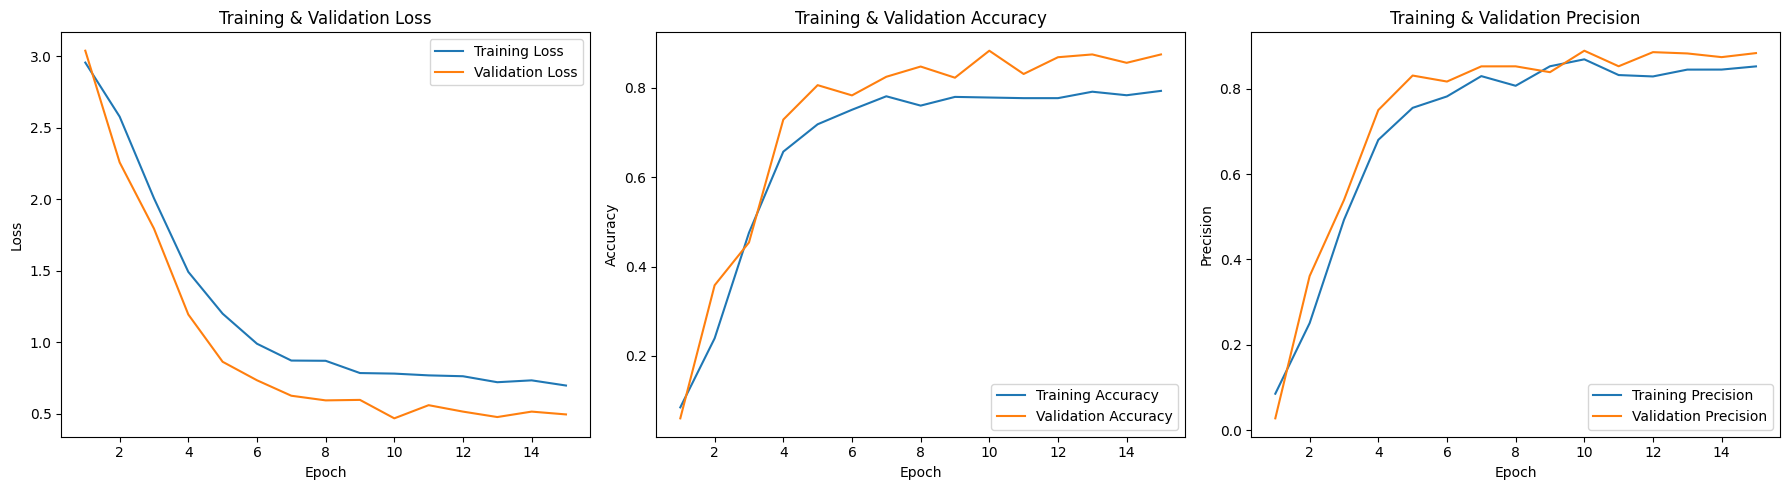

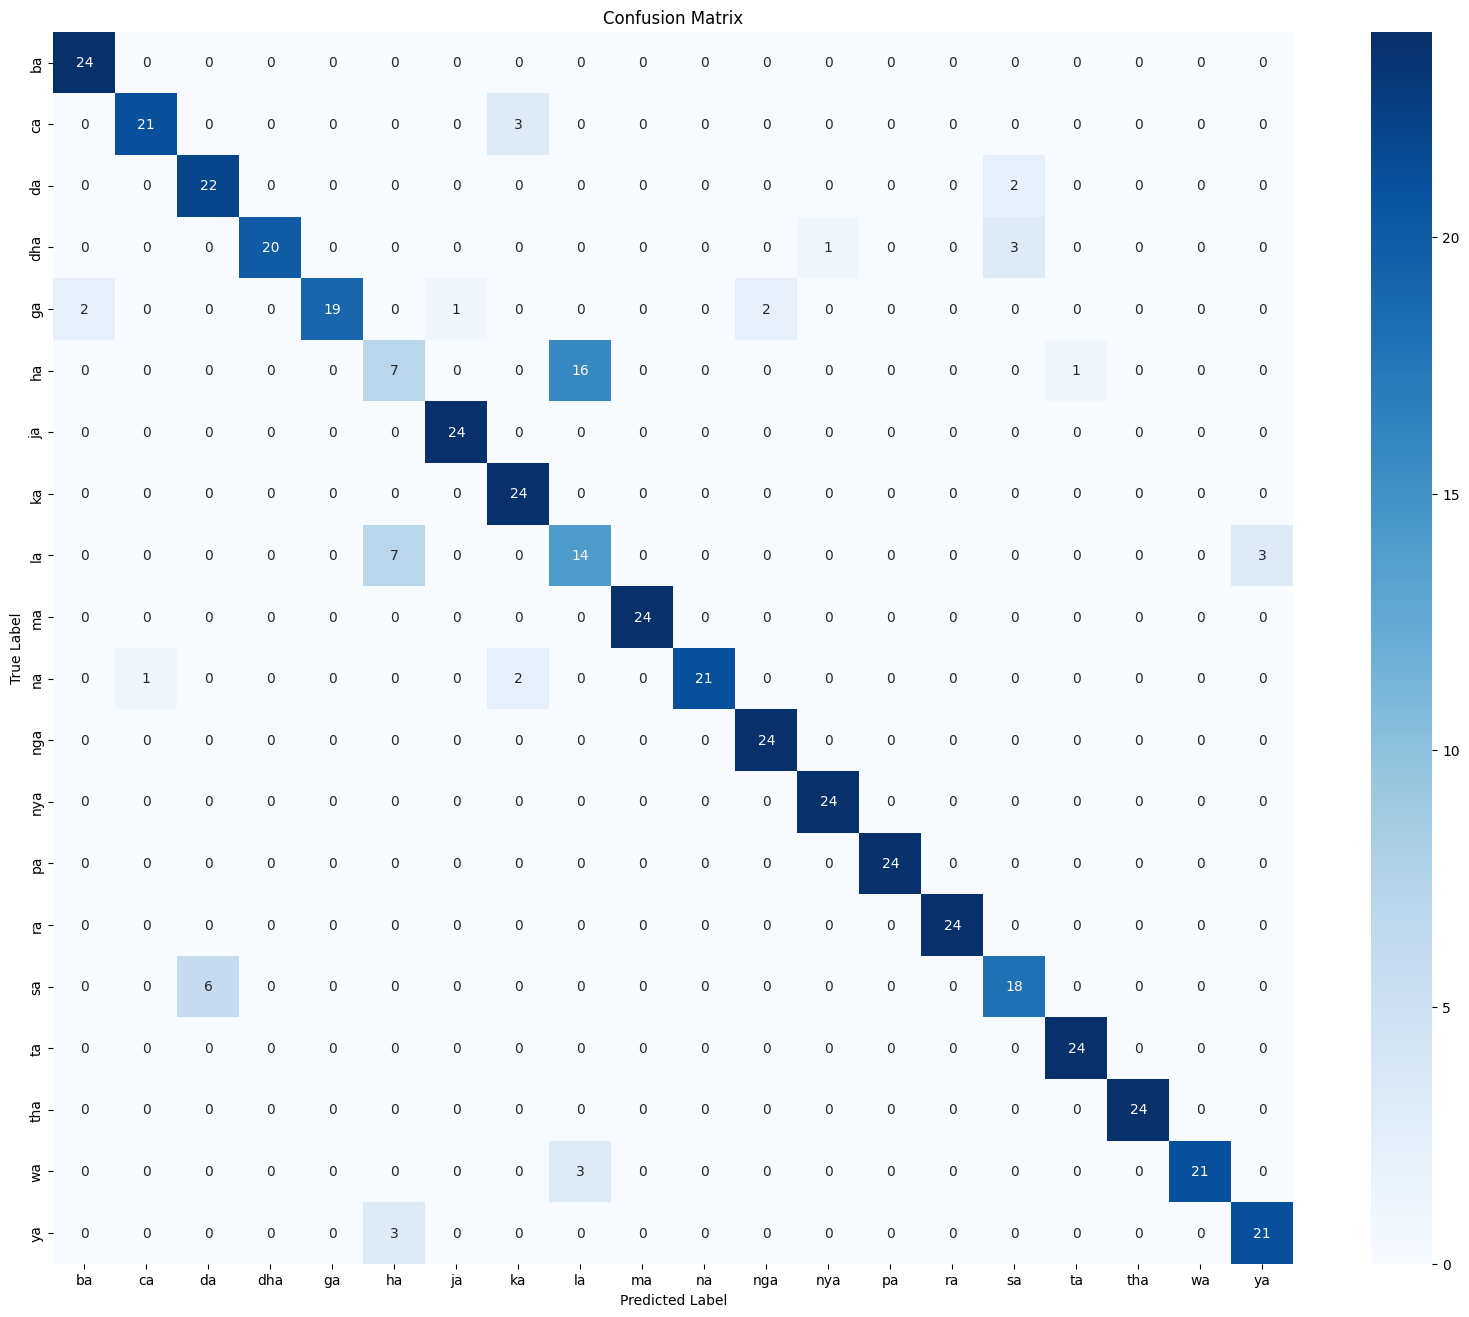

Classification Report:
              precision    recall  f1-score   support

          ba       0.92      1.00      0.96        24
          ca       0.95      0.88      0.91        24
          da       0.79      0.92      0.85        24
         dha       1.00      0.83      0.91        24
          ga       1.00      0.79      0.88        24
          ha       0.41      0.29      0.34        24
          ja       0.96      1.00      0.98        24
          ka       0.83      1.00      0.91        24
          la       0.42      0.58      0.49        24
          ma       1.00      1.00      1.00        24
          na       1.00      0.88      0.93        24
         nga       0.92      1.00      0.96        24
         nya       0.96      1.00      0.98        24
          pa       1.00      1.00      1.00        24
          ra       1.00      1.00      1.00        24
          sa       0.78      0.75      0.77        24
          ta       0.96      1.00      0.98        24
    

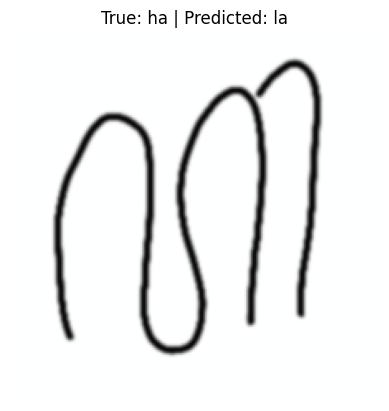

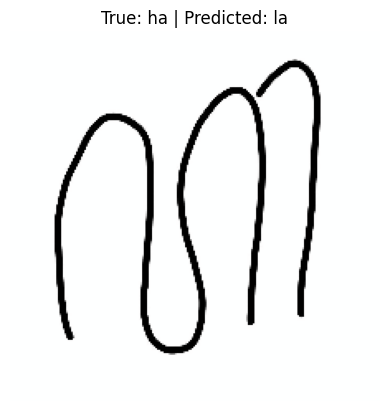

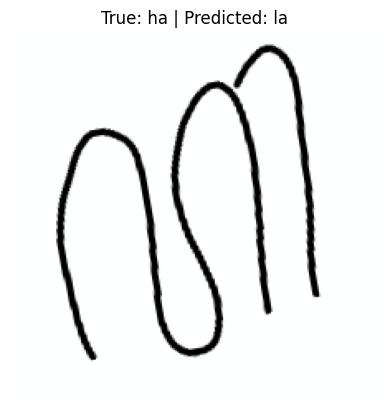

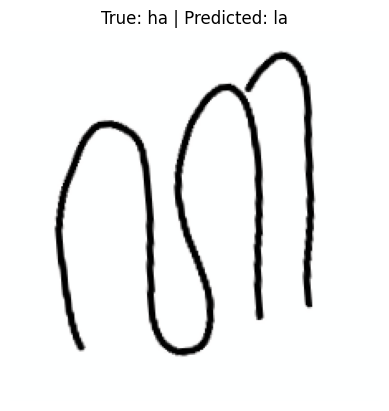

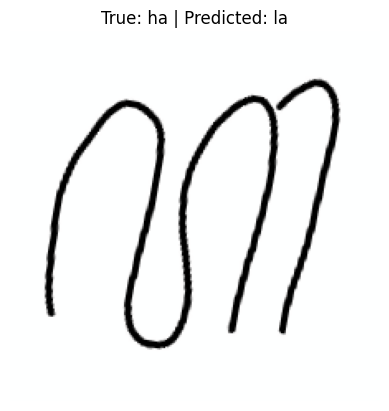

In [5]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import CvtForImageClassification, CvtConfig, AutoImageProcessor
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import numpy as np
import warnings

# Mengabaikan peringatan tertentu (opsional)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ### 3. Persiapan Dataset dan DataLoader

# Path dataset
train_dir = '/kaggle/input/d/phiard/aksara-jawa/v3/v3/train'
val_dir = '/kaggle/input/d/phiard/aksara-jawa/v3/v3/val'
prediction_dir = '/kaggle/input/d/phiard/aksara-jawa/prediction/prediction'

# Inisialisasi Image Processor dari pre-trained CvT
image_processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")

# Definisikan transformasi untuk pelatihan dengan augmentasi data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Definisikan transformasi untuk validasi tanpa augmentasi
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Muat dataset menggunakan ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

# Pastikan jumlah kelas sesuai
num_classes = 20
assert len(train_dataset.classes) == num_classes, f"Jumlah kelas harus {num_classes}, tetapi ditemukan {len(train_dataset.classes)} kelas."
assert len(val_dataset.classes) == num_classes, f"Jumlah kelas harus {num_classes}, tetapi ditemukan {len(val_dataset.classes)} kelas."

# Definisikan DataLoader
batch_size = 32  # Sesuaikan dengan kapasitas GPU Anda
num_workers = 2  # Kurangi untuk mengatasi peringatan multiprocessing

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# ### 4. Inisialisasi Model CvT Pre-trained

# Cek perangkat (GPU atau CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Muat konfigurasi CvT dan sesuaikan jumlah kelas
config = CvtConfig.from_pretrained("microsoft/cvt-13")
config.num_labels = num_classes  # Sesuaikan jumlah label

# Inisialisasi model CvT untuk klasifikasi gambar dengan pre-trained weights
# Tambahkan ignore_mismatched_sizes=True untuk mengabaikan perbedaan ukuran layer classifier
model = CvtForImageClassification.from_pretrained(
    "microsoft/cvt-13", 
    config=config,
    ignore_mismatched_sizes=True
)

# Pindahkan model ke perangkat
model.to(device)

# ### 5. Definisi Optimizer dan Scheduler

# Definisikan optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Total langkah pelatihan
epochs = 50  # Maksimum jumlah epoch, Early Stopping akan menghentikan lebih awal jika diperlukan
patience = 5  # Jumlah epoch tanpa peningkatan sebelum menghentikan pelatihan
total_steps = len(train_loader) * epochs

# Definisikan scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)

# ### 6. Definisi Fungsi Pelatihan dan Validasi

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    for batch in tqdm(dataloader, desc="Training"):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        _, preds = torch.max(logits, dim=1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct.double() / total
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, accuracy.item(), precision

def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(pixel_values=inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            _, preds = torch.max(logits, dim=1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct.double() / total
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, accuracy.item(), precision, all_labels, all_preds

# ### 7. Pelatihan Model dengan Early Stopping

# Inisialisasi list untuk menyimpan metrik pelatihan
train_losses = []
train_accuracies = []
train_precisions = []
val_losses = []
val_accuracies = []
val_precisions = []

best_val_accuracy = 0.0
epochs_no_improve = 0
early_stop = False

for epoch in range(epochs):
    if early_stop:
        print("\nEarly stopping triggered. Menghentikan pelatihan.")
        break
    
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Pelatihan
    train_loss, train_acc, train_prec = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_prec)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training Precision: {train_prec:.4f}")
    
    # Validasi
    val_loss, val_acc, val_prec, val_labels, val_preds = eval_epoch(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Precision: {val_prec:.4f}")
    
    # Cek apakah ada peningkatan akurasi validasi
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        epochs_no_improve = 0
        # Menggunakan torch.save dengan weights_only=True jika memungkinkan
        try:
            torch.save(model.state_dict(), 'best_cvt_model.pth')
            print("Model terbaik disimpan.")
        except:
            torch.save(model.state_dict(), 'best_cvt_model.pth')
            print("Model terbaik disimpan.")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation accuracy for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            early_stop = True

# ### 8. Memuat Model Terbaik dan Evaluasi Akhir

# Muat model terbaik
# Sesuaikan dengan peringatan `torch.load` dengan `weights_only=True` jika tersedia
try:
    model.load_state_dict(torch.load('best_cvt_model.pth', weights_only=True))
except TypeError:
    # Jika torch versi lama, load tanpa weights_only
    model.load_state_dict(torch.load('best_cvt_model.pth'))

# Evaluasi akhir pada data validasi
val_loss, val_acc, val_prec, val_labels, val_preds = eval_epoch(model, val_loader, device)
print(f"\nAkurasi Validasi Terbaik: {val_acc:.4f}, Presisi: {val_prec:.4f}")

# ### 9. Visualisasi Grafik Pelatihan

# Plot Loss, Accuracy, dan Precision
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Precision
plt.subplot(1, 3, 3)
plt.plot(range(1, len(train_precisions)+1), train_precisions, label='Training Precision')
plt.plot(range(1, len(val_precisions)+1), val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training & Validation Precision')
plt.legend()

plt.tight_layout()
plt.show()

# ### 10. Menampilkan Confusion Matrix

# Menggunakan data dari evaluasi terakhir
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=val_dataset.classes, 
            yticklabels=val_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ### 11. Menampilkan Classification Report

print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=val_dataset.classes, zero_division=0))

# ### 12. Hasil Prediksi Per Kelas

# Fungsi untuk menampilkan hasil prediksi per kelas
def show_predictions_per_class(model, dataloader, device, classes, target_class, num_samples=5):
    model.eval()
    samples_shown = 0
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(pixel_values=inputs)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            
            for i in range(len(labels)):
                if labels[i].item() == target_class:
                    image = inputs[i].cpu().permute(1, 2, 0).numpy()
                    # Denormalisasi
                    image = image * np.array(image_processor.image_std) + np.array(image_processor.image_mean)
                    image = np.clip(image, 0, 1)
                    
                    plt.imshow(image)
                    plt.title(f"True: {classes[labels[i].item()]} | Predicted: {classes[preds[i].item()]}")
                    plt.axis('off')
                    plt.show()
                    
                    samples_shown += 1
                    if samples_shown >= num_samples:
                        return

# Contoh: Menampilkan 5 prediksi dari kelas 'ha'
# Pastikan 'ha' adalah salah satu kelas dalam dataset Anda
target_class_name = 'ha'  # Ganti sesuai nama kelas Anda

if target_class_name in train_dataset.classes:
    target_class_index = train_dataset.class_to_idx[target_class_name]
    print(f"\nMenampilkan contoh prediksi untuk kelas: {target_class_name}")
    show_predictions_per_class(model, val_loader, device, train_dataset.classes, target_class_index, num_samples=5)
else:
    print(f"Kelas '{target_class_name}' tidak ditemukan dalam dataset.")

# ### 13. Prediksi pada Gambar Baru

# Berikut adalah contoh bagaimana Anda dapat menggunakan model terlatih untuk memprediksi kelas gambar baru.

from PIL import Image

# Fungsi untuk memprediksi label gambar baru
def predict_image(image_path, model, image_processor, device, classes):
    image = Image.open(image_path).convert('RGB')
    inputs = image_processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
    
    print(f"Predicted label: {classes[predicted_label]}")
    
    # Tampilkan gambar
    plt.imshow(image)
    plt.title(f"Predicted: {classes[predicted_label]}")
    plt.axis('off')
    plt.show()

# Contoh penggunaan:
# image_path = '/kaggle/input/d/phiard/aksara-jawa/prediction/prediction/image1.jpg'  # Ganti dengan path gambar Anda
# predict_image(image_path, model, image_processor, device, train_dataset.classes)
